# 用户消费行为价值分析
- 获取数据并进行预处理，提高数据质量；
- 对用户的各城市分布情况、登录情况进行分析，并分别将结果进行多种形式的可视化展现；
- 构建模型判断用户最终是否会下单购买或下单购买的概率，并将模型结果输出为csv文件（参照结果输出样sample_output.csv）。要求模型的效果达到85%以上；
- 通过用户消费行为价值分析，给企业提出合理的建议。

数据：
- user_info.csv：用户信息表
- login_day.csv: 用户登录情况表
- visit_info.csv: 用户访问统计表
- result.csv: 用户下单表

![字段说明](字段说明.png)

In [117]:
import json
import pydotplus
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyecharts.charts import Map, Bar, Line, Timeline, Liquid, \
                             Pie, Page, Grid, PictorialBar
from pyecharts.commons.utils import JsCode
from pyecharts import options as opts
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, \
                            precision_score, auc, recall_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.core.interactiveshell import InteractiveShell
from pyecharts.globals import CurrentConfig, NotebookType
InteractiveShell.ast_node_interactivity = "all"  # 让变量值可以直接输出多个
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [2]:
# user_info数据的预处理
user_info_df = pd.read_csv('数据/user_info.csv')  # 导入用户信息的数据并进行预处理

'缺失值情况：'
user_info_df.isnull().any()  # 查看各个字段缺失值的情况

# 对city_num字段进行缺失值处理
user_info = user_info_df.replace('error', np.nan)  # 出现error值的替换为NaN
user_info = user_info.fillna('unknown')  # 暂时用unknown值填补缺失值
'unknown替换处理后的数据：'
user_info

# 数据异常值处理
# 我认为年龄字段超过100或是小于5，则是不真实、错误的数据，需要处理。对这些错误数据设为0

user_info[(user_info['age_month'] > 100) | (user_info['age_month'] < 7)]
ab_idx = user_info[(user_info['age_month'] > 100) | (user_info['age_month'] < 5)].index
user_info.loc[ab_idx, 'age_month'] = 0

'缺失值情况：'

user_id              False
first_order_time     False
first_order_price    False
age_month            False
city_num              True
platform_num         False
model_num            False
app_num              False
dtype: bool

'unknown替换处理后的数据：'

user_id  first_order_time  first_order_price  age_month  \
0       2000001555945280  2018/12/23 11:44               0.00         32   
1       2000001556645228    2019/1/11 9:46               0.00        127   
2       2000001558047804  2018/12/26 11:04               0.00         92   
3       2000001558146467   2018/12/31 8:47               0.00         83   
4       2000001558146878    2019/1/28 1:53               0.00         47   
...                  ...               ...                ...        ...   
135963  2000002945827404   2019/5/13 20:20               0.00         60   
135964  2000002945862051   2019/5/13 21:35               0.00         60   
135965  2000002945866461   2019/5/13 21:46               0.00         66   
135966  2000002945873156   2019/5/13 22:10               0.00         24   
135967  2000002946803184   2019/5/13 12:45               0.01         45   

       city_num  platform_num  model_num  app_num  
0            广州        9.2969    11.2707        1  
1            徐州        9.2969     4.9689        1  
2       unknown        9.2969     6.6392        1  
3       unknown        9.2969    12.2222        1  
4       unknown       13.5570    10.3925        1  
...         ...           ...        ...      ...  
135963       徐州       13.5570    10.8966        1  
135964       保定       13.5570     8.1782        1  
135965       西安        9.2969     6.5617        1  
135966       泉州        9.2969    15.3061        1  
135967  unknown        9.2969     8.8308        1  

[135968 rows x 8 columns]

user_id first_order_time  first_order_price  age_month  \
1       2000001556645228   2019/1/11 9:46               0.00        127   
11      2000001559347057  2019/3/16 20:29               0.00        115   
13      2000001560745486   2019/3/1 22:56               0.00        121   
16      2000001560848190   2019/1/26 8:13               0.00        110   
19      2000001561045347  2019/4/21 14:33               0.00        110   
...                  ...              ...                ...        ...   
135909  2000002945402245  2019/5/13 20:51               0.01          0   
135922  2000002945405615  2019/5/13 21:41               0.01        109   
135931  2000002945407300  2019/5/13 22:15               0.00        102   
135934  2000002945408015  2019/5/13 22:27               0.01        316   
135941  2000002945408840  2019/5/13 23:40               0.00        103   

          city_num  platform_num  model_num  app_num  
1               徐州        9.2969     4.9689        1  
11         unknown        9.2969    13.9519        1  
13              成都       13.5570    12.0343        1  
16              天津       13.5570    14.8028        1  
19              邢台        9.2969     9.7331        1  
...            ...           ...        ...      ...  
135909  恩施土家族苗族自治州        9.2969     7.0883        1  
135922          深圳        9.2969     8.9200        1  
135931        齐齐哈尔       13.5570    10.3925        1  
135934          梅州        9.2969     6.0084        1  
135941          无锡       13.5570     8.1782        1  

[13234 rows x 8 columns]

In [3]:
login_day = pd.read_csv('数据/login_day.csv')
result = pd.read_csv('数据/result.csv')
visit_info = pd.read_csv('数据/visit_info.csv')

In [4]:
# user_info的数据可视化
def city_map_func():
    city_counts = user_info['city_num'].value_counts()
    city_counts_list = [[x, y] for x, y in zip(city_counts.index, city_counts.values)]
    with open('area_data.json', 'r', encoding='utf-8') as fp:
        area_data = json.load(fp)
    city_distribution = {}
    for k in area_data.keys():
        city_distribution[k] = 0

    for c in city_counts_list:
        for k, v in area_data.items():
            for i in v:
                if c[0] in i:
                    city_distribution[k] += c[1]

    city_dist = []
    for k, v in city_distribution.items():
        city_dist.append([k, int(v)])  # 一个坑：原本为numpy.int64数据类型，但是在Map画图中显示不了值，只能先转为int
    city_map = (
        Map(init_opts=opts.InitOpts(width="640px", height="480px",
                                    chart_id=1, bg_color='#ADD8E6'))  # 可切换主题
        .set_global_opts(
            title_opts=opts.TitleOpts(title="用户城市分布图"),
            visualmap_opts=opts.VisualMapOpts(
                min_=0,
                max_=13000,
                range_text=['人数区间:', ''],  # 分区间
                is_piecewise=True,    # 定义图例为分段型，默认为连续的图例
                pos_top="middle",     # 分段位置
                pos_left="left",
                orient="vertical",
                split_number=8    # 分成8个区间
            )
        )
        .add("城市分布", city_dist, maptype="china")
    )
    return city_map


city_map = city_map_func()
city_map.load_javascript()

In [5]:
city_map.render('city_map.html')

'C:\\Users\\DELL\\Desktop\\数分赛\\2021年全国大学生数据统计与分析竞赛赛题\\题目B\\city_map.html'

In [6]:
city_map.render_notebook()

In [7]:
# 0-6:儿童 7-17:少年 18-40:青年 41-65:中年 66-:老年
def age_bar_func():
    age_label = ['未知', '儿童', '少年', '青年', '中年', '老年']
    age_fields = pd.cut(user_info['age_month'], [0, 1, 7, 18, 41, 66, 101],
                        right=False, labels=age_label)

    age_lis = list(age_fields.value_counts())
    age_prop = [round(x*100/sum(age_lis), 2) for x in age_lis]

    age_bar = (
        Bar(init_opts=opts.InitOpts(width="640px", height="480px",
                                    chart_id=2, bg_color='#ADD8E6'))
        .add_xaxis(age_label)
        .add_yaxis(
            series_name="各年龄阶段人数",
            y_axis=age_lis,
            label_opts=opts.LabelOpts(position='inside')
        )
        .add_yaxis(
            series_name="各年龄阶段占比",
            y_axis=age_prop,
            yaxis_index=1,
            label_opts=opts.LabelOpts(formatter="{c} %", position='inside')
        )
        .extend_axis(
            yaxis=opts.AxisOpts(
                name="百分比",
                type_="value",
                interval=10,
                axislabel_opts=opts.LabelOpts(formatter="{value} %")
            )
        )
        .set_global_opts(
            yaxis_opts=opts.AxisOpts(
                name="人数",
                type_="value"
            ),
            title_opts=opts.TitleOpts("年龄分布柱状图")
        )
    )
    return age_bar


age_bar = age_bar_func()
age_bar.load_javascript()

In [8]:
age_bar.render('age_bar.html')

'C:\\Users\\DELL\\Desktop\\数分赛\\2021年全国大学生数据统计与分析竞赛赛题\\题目B\\age_bar.html'

In [9]:
age_bar.render_notebook()

In [10]:
# a = user_info['first_order_time'][10]
def order_tl_func():
    user_info['first_order_time'] = pd.to_datetime(user_info['first_order_time'])  # 转换为datetime数据类型

    order_tl = Timeline(init_opts=opts.InitOpts(width="640px", height="480px", chart_id=3))
    for yr in range(2018, 2020):
        yr_df = user_info[user_info['first_order_time'].dt.year == yr][['first_order_time', 'first_order_price']]
        x_month = yr_df['first_order_time'].dt.month.sort_values().unique().astype('int')

        y_price = [yr_df[yr_df['first_order_time'].dt.month == p]['first_order_price'].sum() for p in x_month]
        avg_price = [round(yr_df[yr_df['first_order_time'].dt.month == p]['first_order_price'].mean(), 2) for p in x_month]
        yr_bar = (
            Bar(init_opts=opts.InitOpts(width="640px", height="480px",
                                        bg_color='#ADD8E6'))
            .add_xaxis([str(m) + '月' for m in x_month])
            .add_yaxis("月度收入", y_price, bar_width="15%")
            .add_yaxis("人均付费(ARPU)", avg_price, yaxis_index=1, bar_width="15%")
            .extend_axis(yaxis=opts.AxisOpts(type_="value"))
            .set_global_opts(title_opts=opts.TitleOpts(f"{yr}年订单金额"))
        )
        order_tl.add(yr_bar, "{}年".format(yr))
    return order_tl


order_tl = order_tl_func()
order_tl.load_javascript()

In [11]:
order_tl.render('order_timeline_bar.html')

'C:\\Users\\DELL\\Desktop\\数分赛\\2021年全国大学生数据统计与分析竞赛赛题\\题目B\\order_timeline_bar.html'

In [12]:
order_tl.render_notebook()

In [13]:
def sub_pie_func():
    pie_data_x = ["否", "是"]

    chinese_sub_y = login_day['chinese_subscribe_num'].value_counts()
    math_sub_y = login_day['math_subscribe_num'].value_counts()
    add_friend_y = login_day['add_friend'].value_counts()
    add_group_y = login_day['add_group'].value_counts()
    study_num_y = login_day['study_num'].value_counts()

    chinese_sub_pair = [list(z) for z in zip(pie_data_x, chinese_sub_y)]
    math_sub_pair = [list(z) for z in zip(pie_data_x, math_sub_y)]
    add_friend_pair = [list(z) for z in zip(pie_data_x, add_friend_y)]
    add_group_pair = [list(z) for z in zip(pie_data_x, add_group_y)]
    study_num_pair = [list(z) for z in zip(pie_data_x, study_num_y)]

    fn = """
        function(params) {
            if(params.name == '否')
                return '\\n\\n\\n' + params.name + ' : ' + params.value;
            return params.name + ' : ' + params.value;
        }
        """

    sub_pie = (
        Pie(init_opts=opts.InitOpts(width="640px", height="480px",
                                    chart_id=4, bg_color='#ADD8E6'))
        .add(
            series_name="关注公众号1",
            data_pair=chinese_sub_pair,
            center=["20%", "30%"],
            radius=[50, 80],
            label_opts=opts.LabelOpts(formatter=JsCode(fn), position="center")
        )
        .add(
            series_name="关注公众号2",
            data_pair=math_sub_pair,
            center=["50%", "30%"],
            radius=[50, 80],
            label_opts=opts.LabelOpts(formatter=JsCode(fn), position="center"),
        )
        .add(
            series_name="添加销售好友",
            data_pair=add_friend_pair,
            center=["80%", "30%"],
            radius=[50, 80],
            label_opts=opts.LabelOpts(formatter=JsCode(fn), position="center"),
        )
        .add(
            series_name="进群",
            data_pair=add_group_pair,
            center=["35%", "70%"],
            radius=[50, 80],
            label_opts=opts.LabelOpts(formatter=JsCode(fn), position="center"),
        )
        .add(
            series_name="重复学习",
            data_pair=study_num_pair,
            center=["65%", "70%"],
            radius=[50, 80],
            label_opts=opts.LabelOpts(formatter=JsCode(fn), position="center"),
        )
        .set_global_opts(title_opts=opts.TitleOpts("饼图"))
    )
    return sub_pie


sub_pie = sub_pie_func()
sub_pie.load_javascript()

In [14]:
sub_pie.render('nested_pies.html')

'C:\\Users\\DELL\\Desktop\\数分赛\\2021年全国大学生数据统计与分析竞赛赛题\\题目B\\nested_pies.html'

In [15]:
sub_pie.render_notebook()

In [16]:
def purchase_liquid_func():
    purchase_liquid = (
        Liquid(init_opts=opts.InitOpts(width="640px", height="480px",
                                       chart_id=5, bg_color='#ADD8E6'))
        .add(
            "购买率",
            [round(len(result)/len(user_info), 4)],
            label_opts=opts.LabelOpts(
                formatter=JsCode("function(param) {return (Math.floor(param.value * 10000) / 100) + '%';}"),
                position="inside"
            )
        )
        .set_global_opts(title_opts=opts.TitleOpts(title="购买课程比例"))
    )
    return purchase_liquid


purchase_liquid = purchase_liquid_func()
purchase_liquid.load_javascript()

In [17]:
purchase_liquid.render('purchase_liquid.html')

'C:\\Users\\DELL\\Desktop\\数分赛\\2021年全国大学生数据统计与分析竞赛赛题\\题目B\\purchase_liquid.html'

In [18]:
purchase_liquid.render_notebook()

In [19]:
all_page = Page(layout=Page.DraggablePageLayout, page_title="用户行为数据可视化")

# 在页面中添加图表
all_page.add(
    city_map_func(),
    age_bar_func(),
    order_tl_func(),
    sub_pie_func(),
    purchase_liquid_func()
)

all_page.render('tmp_page.html')

'C:\\Users\\DELL\\Desktop\\数分赛\\2021年全国大学生数据统计与分析竞赛赛题\\题目B\\tmp_page.html'

In [20]:
allp = all_page.save_resize_html('tmp_page.html',
                                 cfg_file='chart_config.json',
                                 dest='用户行为数据可视化.html')

In [21]:
# user_info, login_day, visit_info
# 将数据字段进行整合处理，并筛选用于离散选择模型的特征
ul_merge = pd.merge(user_info, login_day, on='user_id')  # 合并数据表
all_fields = pd.merge(ul_merge, visit_info, on='user_id')
all_fields['result'] = all_fields['user_id'].apply(lambda x: 1 if x in result['user_id'].values else 0)

drop_fea = ['first_order_time', 'city_num', 'platform_num', 'model_num',
            'app_num', 'add_friend', 'add_group', 'launch_time']
# drop_fea2 = ['main_home2', 'main_mime', 'click_buy', 'first_order_price']
# 去除非数值型的字段，app_num字段值全为1，对模型的拟合没有多大用处，也去除
all_fields.drop(drop_fea, axis=1, inplace=True)

In [22]:
# 继续调整字段，通过计算字段相关系数，去除一些高相关性的以及不显著的字段
fields_corrs = all_fields.iloc[:, 1:-1].corr()
large_corr = []
for i in range(fields_corrs.shape[0]):
    for j in range(i+1, fields_corrs.shape[1]):
        if fields_corrs.iloc[i, j] > 0.8:  # 找出相关性大于0.8的字段
            large_corr.append([fields_corrs.index[i], fields_corrs.columns[j], fields_corrs.iloc[i, j]])
large_corr

[['learn_num', 'finish_num', 0.9033323860762515],
 ['main_home', 'main_home2', 0.8284737973700508],
 ['main_home', 'task', 0.8087530780284601],
 ['ppt', 'task', 0.8270569708588488],
 ['task', 'video_read', 0.8659360598420046],
 ['task', 'next_nize', 0.8122987711623785]]

In [23]:
drop_fea2 = ['main_home2', 'main_mime', 'click_buy', 'first_order_price']
all_fields.drop(drop_fea2, axis=1, inplace=True)

In [24]:
# 确定保留的字段后，将数据集分割为训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(all_fields.iloc[:, 1:-1],
                                                    all_fields['result'],
                                                    test_size=0.2,
                                                    stratify=all_fields['result'],
                                                    random_state=0)

In [119]:
logit_clf = LogisticRegression(solver='newton-cg')  # 使用牛顿法求解器
%time logit_clf.fit(x_train, y_train)  # 拟合训练集

logit_prob = logit_clf.predict_proba(x_test)  # 预测测试集类别的概率
logit_pred = logit_clf.predict(x_test)       # 预测测试集的类别

logit_fpr, logit_tpr, _ = roc_curve(y_test, logit_prob[:, 1])  # 得到真假阳性率数据
logit_area = round(roc_auc_score(y_test, logit_prob[:, 1]), 3)  # AUC值，保留3位小数
logit_precision, logit_recall, _ = precision_recall_curve(y_test, logit_prob[:, 1])  # 得到准确率和召回率的数据
logit_pr_auc = round(auc(logit_recall, logit_precision), 3)

logit_Accuracy = round(logit_clf.score(x_test, y_test), 3)  # 返回的是测试集预测类别与实际类别的准确度
logit_Precision = round(precision_score(y_test, logit_pred), 3)
logit_Recall = round(recall_score(y_test, logit_pred), 3)
logit_F1_score = round(f1_score(y_test, logit_pred), 3)

Wall time: 15.2 s


LogisticRegression(solver='newton-cg')

In [26]:
# 对模型进行评估与可视化
logit_roc_line = (
    Line()
    .add_xaxis(logit_fpr)
    .add_yaxis(
        series_name=f'ROC曲线(AUC值{logit_area})',
        y_axis=logit_tpr,
        is_symbol_show=False,
        is_smooth=True
    )
    .add_yaxis(
        series_name='y=x',
        y_axis=logit_fpr,
        is_symbol_show=False
    )
    .set_global_opts(
        xaxis_opts=opts.AxisOpts(name="假阳性率(FPR)"),
        yaxis_opts=opts.AxisOpts(
            name="真阳性率(TPR)",
            splitline_opts=opts.SplitLineOpts(is_show=True),
            is_scale=True,
        ),
        legend_opts=opts.LegendOpts(pos_left="20%")
    )
)

logit_pr_line = (
    Line()
    .add_xaxis(logit_recall)
    .add_yaxis(
        series_name='PR曲线',
        y_axis=logit_precision,
        is_symbol_show=False,
        is_smooth=True
    )
    .set_global_opts(
        xaxis_opts=opts.AxisOpts(name="召回率(Recall)"),
        yaxis_opts=opts.AxisOpts(
            name="准确率(Precision)",
            splitline_opts=opts.SplitLineOpts(is_show=True),
            is_scale=True
        ),
        legend_opts=opts.LegendOpts(pos_right="20%")
    )
)

# roc_pr_line = roc_line.overlap(pr_line)
logit_roc_pr_line = (
    Grid(init_opts=opts.InitOpts(width="1000px", height="500px"))
    .add(logit_roc_line, grid_opts=opts.GridOpts(pos_right="60%"))
    .add(logit_pr_line, grid_opts=opts.GridOpts(pos_left="60%"))
)

logit_roc_pr_line.load_javascript()

In [27]:
# roc_line.render_notebook()
logit_roc_pr_line.render_notebook()

[参考](https://cuijiahua.com/blog/2017/11/ml_3_decision_tree_2.html)

决策树的一些优点：

- 易于理解和解释。决策树可以可视化。
- 几乎不需要数据预处理。其他方法经常需要数据标准化，创建虚拟变量和删除缺失值。决策树还不支持缺失值。
- 使用树的花费（例如预测数据）是训练数据点(data points)数量的对数。
- 可以同时处理数值变量和分类变量。其他方法大都适用于分析一种变量的集合。
- 可以处理多值输出变量问题。
- 使用白盒模型。如果一个情况被观察到，使用逻辑判断容易表示这种规则。相反，如果是黑盒模型（例如人工神经网络），结果会非常难解释。
- 即使对真实模型来说，假设无效的情况下，也可以较好的适用。

决策树的一些缺点：

- 决策树学习可能创建一个过于复杂的树，并不能很好的预测数据。也就是过拟合。修剪机制（现在不支持），设置一个叶子节点需要的最小样本数量，或者数的最大深度，可以避免过拟合。
- 决策树可能是不稳定的，因为即使非常小的变异，可能会产生一颗完全不同的树。这个问题通过decision trees with an ensemble来缓解。
- 概念难以学习，因为决策树没有很好的解释他们，例如，XOR, parity or multiplexer problems。
- 如果某些分类占优势，决策树将会创建一棵有偏差的树。因此，建议在训练之前，先抽样使样本均衡。

In [120]:
# 采用决策树模型进行分类
# 使用信息熵作为划分标准，最大深度为5，对决策树进行训练
tree_clf = tree.DecisionTreeClassifier(criterion='entropy',
                                       max_depth=5, random_state=0)
%time tree_fit = tree_clf.fit(x_train, y_train)  # 拟合训练集

with open("tree.dot", 'w') as f:  # 保存决策树的结果，后续进行可视化
    f = tree.export_graphviz(tree_fit, out_file=f,
                             feature_names=x_train.columns,
                             class_names=[str(cl) for cl in tree_fit.classes_],
                             filled=True, rounded=True,
                             special_characters=True)

with open("tree.dot", 'r') as fp:
    dot_code = fp.read()
    graph = pydotplus.graph_from_dot_data(dot_code)
    graph.write_pdf("tree.pdf")  # pydotplus对决策树的代码进行可视化，生成PDF文件

tree_pred = tree_clf.predict(x_test)   # 预测测试集类别
tree_prob = tree_clf.predict_proba(x_test)   # 测试集类别的概率

tree_fpr, tree_tpr, _ = roc_curve(y_test, tree_prob[:, 1])  # 得到真假阳性率数据
tree_area = round(roc_auc_score(y_test, tree_prob[:, 1]), 3)  # AUC值，保留3位小数
tree_precision, tree_recall, _ = precision_recall_curve(y_test, tree_prob[:, 1])  # 得到准确率和召回率的数据
tree_pr_auc = round(auc(tree_recall, tree_precision), 3)

tree_Accuracy = round(tree_clf.score(x_test, y_test), 3)  # 模型精度
tree_Precision = round(precision_score(y_test, tree_pred), 3)
tree_Recall = round(recall_score(y_test, tree_pred), 3)
tree_F1_score = round(f1_score(y_test, tree_pred), 3)

Wall time: 677 ms


True

In [102]:
tree_fea_imp = pd.Series(tree_clf.feature_importances_,
                         index=all_fields.columns[1:-1])
tree_fea_imp.sort_values(inplace=True)
fea_translate = pd.Series(pd.read_excel('字段说明.xlsx',
                                        index_col=0, usecols=[1, 2])['含义'])
fea_name = [fea_translate[x] for x in tree_fea_imp.index[-7:]]
fea_importance = [round(x, 2) for x in tree_fea_imp[-7:]]

with open("symbol.json", "r", encoding="utf-8") as f:
    symbols = json.load(f)

importance_bar = (
    PictorialBar(init_opts=opts.InitOpts(width="640px", height="480px"))
    .add_xaxis(fea_name)
    .add_yaxis(
        series_name='特征重要程度',
        y_axis=fea_importance,
        label_opts=opts.LabelOpts(is_show=False),
        symbol_size=20,
        symbol_repeat="fixed",
        is_symbol_clip=True,
        color='blue',
        symbol=symbols['lightning']
    )
    .reversal_axis()
    .set_global_opts(
        xaxis_opts=opts.AxisOpts(is_show=False),
        yaxis_opts=opts.AxisOpts(
            axistick_opts=opts.AxisTickOpts(is_show=False),
            axisline_opts=opts.AxisLineOpts(
                linestyle_opts=opts.LineStyleOpts(opacity=0)
            ),
            axislabel_opts=opts.LabelOpts(
                font_size=8,
                rotate=20,
                margin=4,
                horizontal_align='right')
        )
    )
)
importance_bar.load_javascript()

In [103]:
importance_bar.render('feature_importance.html')

'C:\\Users\\DELL\\Desktop\\数分赛\\2021年全国大学生数据统计与分析竞赛赛题\\题目B\\feature_importance.html'

In [104]:
importance_bar.render_notebook()

In [32]:
# 对模型进行评估与可视化
tree_roc_line = (
    Line()
    .add_xaxis(tree_fpr)
    .add_yaxis(
        series_name=f'ROC曲线(AUC值={tree_area})',
        y_axis=tree_tpr,
        is_symbol_show=False,
        is_smooth=True
    )
    .add_yaxis(
        series_name='y=x',
        y_axis=tree_fpr,
        is_symbol_show=False
    )
    .set_global_opts(
        xaxis_opts=opts.AxisOpts(name="假阳性率(FPR)"),
        yaxis_opts=opts.AxisOpts(
            name="真阳性率(TPR)",
            splitline_opts=opts.SplitLineOpts(is_show=True),
            is_scale=True,
        ),
        legend_opts=opts.LegendOpts(pos_left="20%")
    )
)

tree_pr_line = (
    Line()
    .add_xaxis(tree_recall)
    .add_yaxis(
        series_name='PR曲线',
        y_axis=tree_precision,
        is_symbol_show=False,
        is_smooth=True
    )
    .set_global_opts(
        xaxis_opts=opts.AxisOpts(name="召回率(Recall)"),
        yaxis_opts=opts.AxisOpts(
            name="准确率(Precision)",
            splitline_opts=opts.SplitLineOpts(is_show=True),
            is_scale=True
        ),
        legend_opts=opts.LegendOpts(pos_right="20%")
    )
)


# roc_pr_line = roc_line.overlap(pr_line)
tree_roc_pr_line = (
    Grid(init_opts=opts.InitOpts(width="1000px", height="500px"))
    .add(tree_roc_line, grid_opts=opts.GridOpts(pos_right="60%"))
    .add(tree_pr_line, grid_opts=opts.GridOpts(pos_left="60%"))
)

tree_roc_pr_line.load_javascript()

In [33]:
tree_roc_pr_line.render_notebook()

In [121]:
lsvm_clf = LinearSVC(dual=False, random_state=0)  # 样本量大于特征数，将对偶项设为False
%time lsvm_clf.fit(x_train, y_train)   # 拟合训练集

lsvm_pred = lsvm_clf.predict(x_test)  # 预测测试集
lsvm_prob = lsvm_clf._predict_proba_lr(x_test)  # 测试集类别的概率

lsvm_fpr, lsvm_tpr, _ = roc_curve(y_test, lsvm_prob[:, 1])  # 得到真假阳性率数据
lsvm_area = round(roc_auc_score(y_test, lsvm_prob[:, 1]), 3)  # AUC值，保留3为小数
lsvm_precision, lsvm_recall, _ = precision_recall_curve(y_test, lsvm_prob[:, 1])  # 准确率与回归率
lsvm_pr_auc = round(auc(lsvm_recall, lsvm_precision), 3)

lsvm_Accuracy = round(lsvm_clf.score(x_test, y_test), 3)  # 模型精度
lsvm_Precision = round(precision_score(y_test, lsvm_pred), 3)
lsvm_Recall = round(recall_score(y_test, lsvm_pred), 3)
lsvm_F1_score = round(f1_score(y_test, lsvm_pred), 3)

Wall time: 8.61 s


LinearSVC(dual=False, random_state=0)

In [36]:
# 对模型进行评估与可视化
lsvm_roc_line = (
    Line()
    .add_xaxis(lsvm_fpr)
    .add_yaxis(
        series_name=f'ROC曲线(AUC值={lsvm_area})',
        y_axis=lsvm_tpr,
        is_symbol_show=False,
        is_smooth=True
    )
    .add_yaxis(
        series_name='y=x',
        y_axis=lsvm_fpr,
        is_symbol_show=False
    )
    .set_global_opts(
        xaxis_opts=opts.AxisOpts(name="假阳性率(FPR)"),
        yaxis_opts=opts.AxisOpts(
            name="真阳性率(TPR)",
            splitline_opts=opts.SplitLineOpts(is_show=True),
            is_scale=True,
        ),
        legend_opts=opts.LegendOpts(pos_left="20%")
    )
)

lsvm_pr_line = (
    Line()
    .add_xaxis(lsvm_recall)
    .add_yaxis(
        series_name='PR曲线',
        y_axis=lsvm_precision,
        is_symbol_show=False,
        is_smooth=True
    )
    .set_global_opts(
        xaxis_opts=opts.AxisOpts(name="召回率(Recall)"),
        yaxis_opts=opts.AxisOpts(
            name="准确率(Precision)",
            splitline_opts=opts.SplitLineOpts(is_show=True),
            is_scale=True
        ),
        legend_opts=opts.LegendOpts(pos_right="20%")
    )
)


lsvm_roc_pr_line = (
    Grid(init_opts=opts.InitOpts(width="1000px", height="500px"))
    .add(lsvm_roc_line, grid_opts=opts.GridOpts(pos_right="60%"))
    .add(lsvm_pr_line, grid_opts=opts.GridOpts(pos_left="60%"))
)

lsvm_roc_pr_line.load_javascript()

In [37]:
lsvm_roc_pr_line.render_notebook()

Text(0.5, 1.0, 'ROC曲线')

Text(0.5, 0, '假阳性率(FPR)')

Text(0, 0.5, '真阳性率(TPR)')

Text(0.5, 1.0, 'PR曲线')

Text(0.5, 0, '召回率(Recall)')

Text(0, 0.5, '准确率(Precision)')

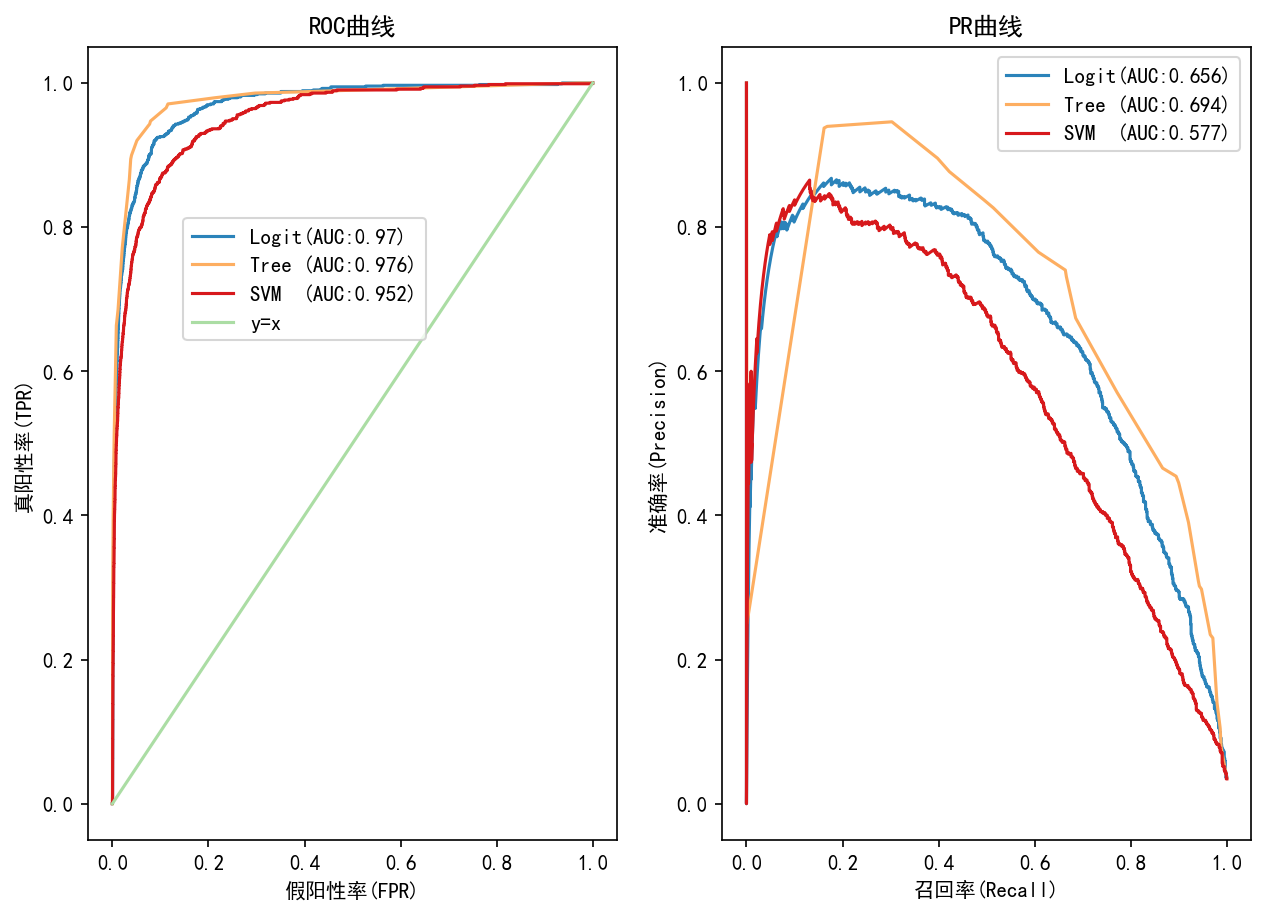

In [38]:
# 总结与对比
# 对模型进行评估与可视化
fig, ax = plt.subplots(ncols=2, figsize=[10, 7], dpi=150)

ax[0].plot(logit_fpr, logit_tpr, color='#2b83ba')  # Logit ROC曲线
ax[0].plot(tree_fpr, tree_tpr, color='#fdae61')    # Tree ROC曲线
ax[0].plot(lsvm_fpr, lsvm_tpr, color='#d7191c')    # SVM ROC曲线
ax[0].plot(logit_tpr, logit_tpr, color='#abdda4')  # 对比y=x
ax[0].legend([f'Logit(AUC:{logit_area})', f'Tree (AUC:{tree_area})',
              f'SVM  (AUC:{lsvm_area})', 'y=x'], loc=[0.18, 0.63])
ax[0].set_title('ROC曲线')
ax[0].set_xlabel('假阳性率(FPR)')
ax[0].set_ylabel('真阳性率(TPR)')

ax[1].plot(logit_recall, logit_precision, color='#2b83ba')  # Logit ROC曲线
ax[1].plot(tree_recall, tree_precision, color='#fdae61')    # Tree ROC曲线
ax[1].plot(lsvm_recall, lsvm_precision, color='#d7191c')    # SVM ROC曲线
ax[1].legend([f'Logit(AUC:{logit_pr_auc})', f'Tree (AUC:{tree_pr_auc})',
              f'SVM  (AUC:{lsvm_pr_auc})'])
ax[1].set_title('PR曲线')
ax[1].set_xlabel('召回率(Recall)')
ax[1].set_ylabel('准确率(Precision)')

plt.savefig('roc_pr_fig.png', dpi=200)
plt.show()

In [148]:
all_indicate = ['Accuracy', 'Precision', 'Recall',
                'F1-Score', 'ROC-AUC', 'PR-AUC']
logit_indicate_y = [logit_Accuracy, logit_Precision, logit_Recall,
                    logit_F1_score, logit_area, logit_pr_auc]
tree_indicate_y = [tree_Accuracy, tree_Precision, tree_Recall,
                   tree_F1_score, tree_area, tree_pr_auc]
lsvm_indicate_y = [lsvm_Accuracy, lsvm_Precision, lsvm_Recall,
                   lsvm_F1_score, lsvm_area, lsvm_pr_auc]
all_indicate_bar = (
    Bar(init_opts=opts.InitOpts(width='640px', height='480px'))
    .add_xaxis(all_indicate)
    .add_yaxis(
        series_name='Logit',
        y_axis=logit_indicate_y,
        category_gap='30%',
        gap='60%',
        label_opts=opts.LabelOpts(position='inside')
    )
    .add_yaxis(
        series_name='Tree',
        y_axis=tree_indicate_y,
        category_gap='30%',
        gap='60%',
        label_opts=opts.LabelOpts(position='inside')
    )
    .add_yaxis(
        series_name='SVM',
        y_axis=lsvm_indicate_y,
        category_gap='30%',
        gap='60%',
        label_opts=opts.LabelOpts(position='inside')
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title='模型指标比较'),
        xaxis_opts=opts.AxisOpts(name='指标', position='right'),
        yaxis_opts=opts.AxisOpts(
            axistick_opts=opts.AxisTickOpts(is_show=False)
        )
    )
)
all_indicate_bar.load_javascript()

In [149]:
all_indicate_bar.render_notebook()

In [150]:
all_indicate_bar.render('model_compare_1008.html')

'C:\\Users\\DELL\\Desktop\\数分赛\\2021年全国大学生数据统计与分析竞赛赛题\\题目B\\model_compare_1008.html'

In [114]:
logit_Accuracy
tree_Accuracy
lsvm_Accuracy

0.978

0.98

0.971

In [115]:
logit_Precision
tree_Precision
lsvm_Precision

0.816

0.74

0.831

In [116]:
logit_Recall
tree_Recall
lsvm_Recall

0.46

0.664

0.185

In [122]:
logit_F1_score
tree_F1_score
lsvm_F1_score

0.589

0.7

0.303